In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab
import torch
import sys
import time
sys.path.insert(1, '/home/nicolas/code/src')
sys.path.insert(1, '/home/nicolas/code/data')

from RBM import RBM
from scipy.integrate import simps
from scipy import stats
import h5py

device = torch.device("cuda")
dtype = torch.float
torch.set_num_threads(4)

In [2]:
def TMCSample(v, w_hat, N, V, it_mcmc=100, it_mean=50, ß=1):
    #print("Initialisation")
    #s = time.time()
    vtab = torch.zeros(v.shape, device = device)
    v_curr = v
    #V = V
    norm = 1/(v_curr.shape[0]**0.5)
    w_curr = (torch.mv(v_curr.T, V)*norm)
    
    index = torch.randperm(v_curr.shape[0])
    #print(time.time()-s)
    #print("IT MCMC")
    s = time.time()

    for t in range(it_mcmc):
        #print('init it')
        print(t)
        h_curr, _ = myRBM.SampleHiddens01(v_curr)
        h_i = (torch.mm(myRBM.W.T, h_curr)+myRBM.vbias.reshape(v.shape[0],1)) # Nv x Ns
        w_next = w_curr.clone()
        
        v_next = torch.clone(v_curr)
        index = torch.randperm(v_curr.shape[0])
        for idx in range(v_curr.shape[0]):
            #print('upd comp')
            s = time.time()
            i = idx
            v_next[i,:] = 1-v_curr[i,:]
            w_next += ((2*v_next[i,:]-1)*V[i]*norm)

            # On calcul -DeltaE
            ΔE = ß*((2*v_next[i,:]-1)*h_i[i,:])-(N/2)*((w_hat-w_next)**2-(w_hat-w_curr)**2)

            tir = torch.rand(v_curr.shape[1],1, device = torch.device("cuda")).squeeze()
            prob = torch.exp(ΔE).squeeze()
            v_curr[i,:] = torch.where(tir<prob, v_next[i,:], v_curr[i,:])
            v_next[i,:] = torch.where(tir<prob, v_next[i,:], 1-v_next[i,:])
            w_curr = torch.where(tir<prob, w_next, w_curr)
            w_next = torch.where(tir<prob, w_next, w_curr)
            #print(time.time()-s)
        if (t>= (it_mcmc-it_mean)):
            vtab += v_curr
    print(time.time()-s)

    vtab = vtab*(1/it_mean)    
    return v_curr, h_curr, vtab

In [3]:
data = torch.tensor(np.genfromtxt('../dataset/C1d5c/data_5.dat'), device = device, dtype = dtype)

data = (data+1)/2

In [4]:
W = np.genfromtxt('../dataset/C1d5c/rbm_W.dat').T
vbias = np.genfromtxt('../dataset/C1d5c/rbm_vis.dat')
hbias = -np.genfromtxt('../dataset/C1d5c/rbm_hid.dat')
data = np.genfromtxt('../dataset/C1d5c/data_5.dat')
data = (data+1)/2

lr = 0.01
l2 = 0
NGibbs = 10
annSteps = 0
mb_s = 500
num_pcd = 500
Nh = W.shape[0]
Nv = W.shape[1]
print(Nh)
ep_max = 100
myRBM = RBM(num_visible=Nv,
				num_hidden=Nh,
				device=device,
				lr=lr,
				#regL2=l2,
				gibbs_steps=NGibbs,
				#anneal_steps=annSteps,
				UpdCentered=True,
				mb_s=mb_s,
				num_pcd=num_pcd)

myRBM.W = torch.tensor(4*W).float().cuda()
myRBM.vbias = torch.tensor(2*vbias - 2*W.sum(0)).float().to(device)
myRBM.hbias = torch.tensor(2*hbias - 2*W.sum(1)).float().to(device)
_, _, V = torch.svd(torch.tensor(4*W).float().cuda())


20


In [5]:
nb_chain = 10 # Nb de chaines pour chaque w_hat
it_mcmc = 150 # Nb it_mcmc pour chaque chaine
it_mean = 100 # Nb it considérée pour la moyenne temporelle de chaque chaine
N = 20000 # Contrainte
nb_point = 15000 # Nb de points de discrétisation pour w_hat
xmin = -0.0 
xmax = 1.0

In [6]:
start = torch.bernoulli(torch.rand(myRBM.Nv, nb_chain*nb_point, device = device))
V0 = V[:,0]
# w_hat = torch.dot(start.T, V)[0:,]
w_hat_b = torch.linspace(xmin, xmax, steps =nb_point, device = device)
w_hat = torch.zeros(nb_chain*nb_point, device = device)
for i in range(nb_point):
    for j in range(nb_chain):
        w_hat[i*nb_chain+j] = w_hat_b[i]
tmpv, tmph, vtab = TMCSample(start, w_hat, N, V0, it_mcmc = it_mcmc, it_mean=it_mean)

y = np.array(torch.mm(vtab.T, V0.unsqueeze(1)).cpu().squeeze())/myRBM.Nv**0.5
newy = np.array([np.mean(y[i*nb_chain:i*nb_chain+nb_chain]) for i in range(nb_point)])
w_hat = w_hat.cpu().numpy()
w_hat_b = w_hat_b.cpu().numpy()
res=np.zeros(len(w_hat_b)-1)
for i in range(1,len(w_hat_b)):
    res[i-1] = simps(newy[:i]-w_hat_b[:i], w_hat_b[:i])
const = simps(np.exp(N*res), w_hat_b[:-1])
p_m = np.exp(N*res)/const
print(simps(p_m, w_hat_b[:-1]))
potential = res + (1/N)*np.log(const)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
0.00035262107849121094
1.0


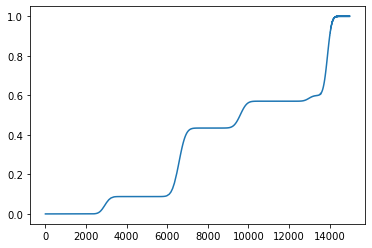

In [8]:
cdf = np.zeros(len(p_m)-1)
for i in range(1,len(p_m)):
    cdf[i-1] = simps(p_m[:i], w_hat_b[:i])
plt.plot(cdf)


In [9]:
def sample(cdf, n_sample):
    sample = torch.rand(n_sample)
    for i in range(n_sample):
        for k in range(len(cdf)-1):
            if cdf[k+1]>sample[i]:
                sample[i] = k
                break
    return sample
    

In [14]:
s = sample(cdf, 1000)


tensor([ 6520.,  7030.,  9372., 14000.,  9744.,  6836.,  2912., 14074.,  6100.,
         6384., 13962.,  7084., 14194.,  9178.,  3056.,  6469.,  9314., 13882.,
         6514., 14002.,  2715., 13966., 13857.,  9856., 13887.,  6782.,  2833.,
         6244.,  2552., 13722.,  6390., 14016., 13869., 13771.,  6564., 13910.,
        13954.,  6914., 14026.,  9552.,  9614.,  2836.,  6290., 13890.,  3062.,
         6185., 14006.,  3176.,  9270., 10196.,  9948., 13866., 14020.,  7048.,
        13954., 14194.,  3109., 13784., 13884.,  6770.,  3171., 13993.,  6312.,
         7004., 14182., 14074.,  6434., 13924., 13964.,  9740.,  6334.,  6760.,
         6994.,  6504.,  9706.,  6235., 13910.,  9832., 13657.,  9670., 13987.,
         6285., 13985.,  3112.,  6820., 13728., 13896.,  6570., 13769., 13914.,
         9300.,  7340., 14056., 14144., 13954., 14096.,  6379., 13904., 14132.,
         9553.,  6771., 14128.,  6631., 14012., 13766., 13915., 13954., 13965.,
        13996., 14262., 14116., 13942., 

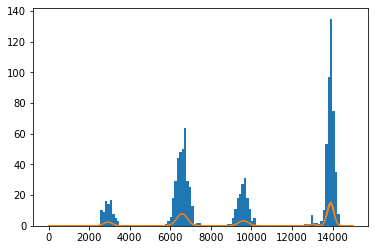

In [23]:
plt.hist(s.cpu().numpy(), bins = 100);
plt.plot(p_m)

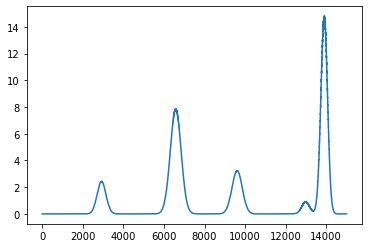

In [7]:
plt.plot(p_m)